<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/WQCLAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wine Quality Dataset for classification

In [ ]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle
import copy
import time
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

#Connect to drive
from google.colab import drive
drive.mount('/content/drive')



#Convert and import personalised library
!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilsTFG


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/utilsTFG.ipynb to python
[NbConvertApp] Writing 48517 bytes to /content/drive/MyDrive/Colab Notebooks/utilsTFG.py


In [ ]:
#The dataset is so imbalanced that we need to avoid this warning because its too annoying.
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Set seed for fastai
fastai.torch_core.set_seed(42)

# Set seed for torch
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)

# Set seed for numpy
np.random.seed(42)

### Datos y modelos

In [ ]:
dataset='wqc'
plot_dataset='WQC'

#Download the dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)

X = wine_quality.data.features
y = wine_quality.data.targets

#Show the data
print(X.head())



# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'quality'


df=pd.concat([X, y], axis=1)

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4  
{'uci_id

In [ ]:
#Show if there is missing data
missing_values = df.isna().sum()
print(missing_values)

#Handle the missing data, filling with the mean
#mis_col = []
#df[mis_col] = df[mis_col].fillna(df.mean())


fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


quality                 1.000000
alcohol                 0.444319
density                 0.305858
volatile_acidity        0.265699
chlorides               0.200666
citric_acid             0.085532
fixed_acidity           0.076743
free_sulfur_dioxide     0.055463
total_sulfur_dioxide    0.041385
sulphates               0.038485
residual_sugar          0.036980
pH                      0.019506
dtype: float64


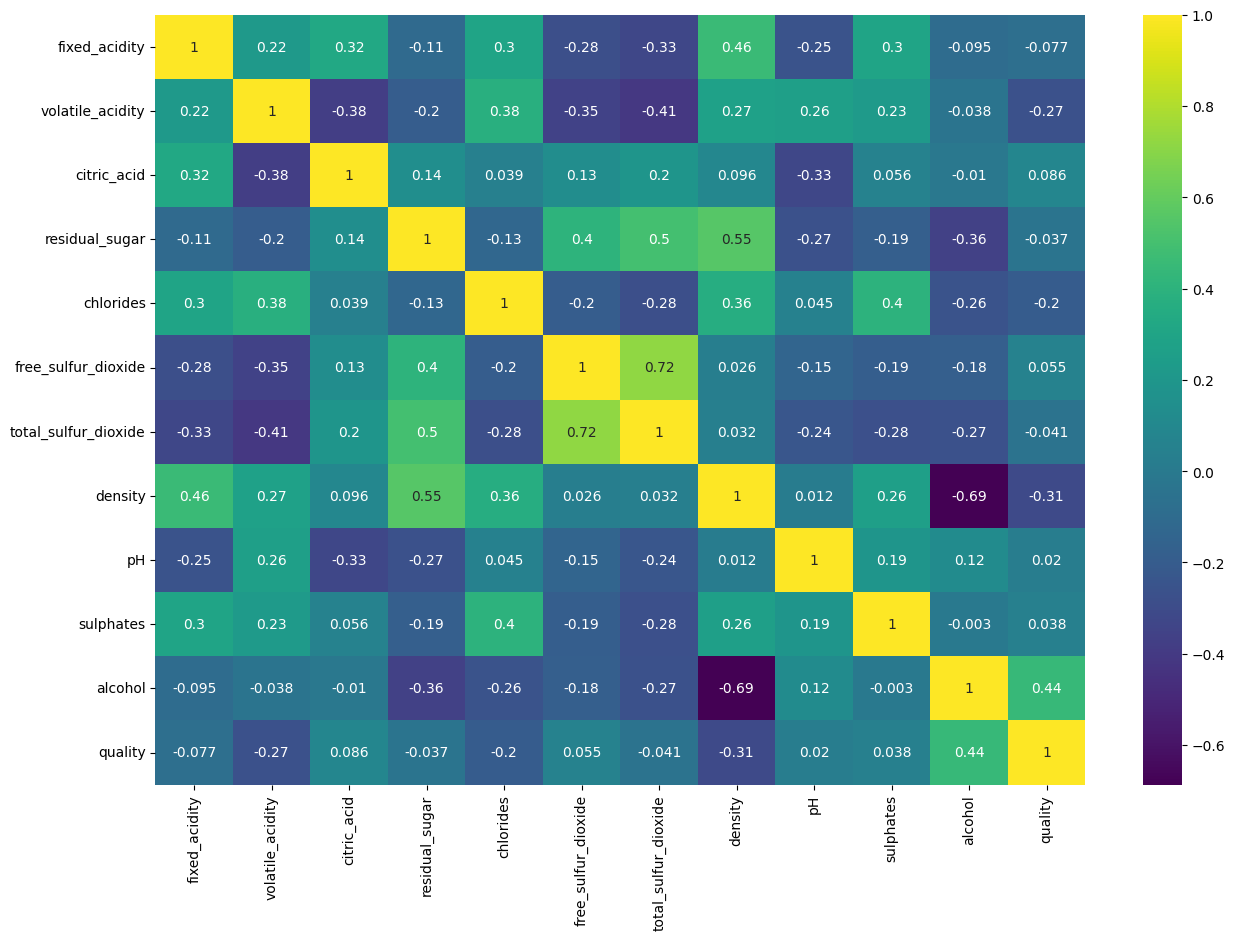

In [ ]:
##Preprocessing

#Correlation of all features with the target
corr_mat = df.corr()[dep_var]
target_corr = np.abs(df.corrwith(df[dep_var]))
print(target_corr.sort_values(ascending=False))

#Correlation of features with each other
corr_matrix = df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix,cmap="viridis", annot=True)
plt.show()


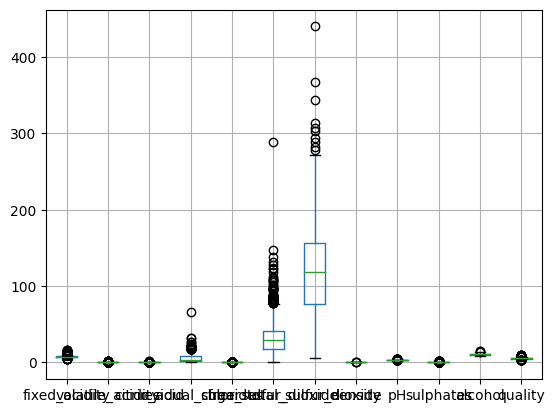

In [ ]:
#Boxplot to see the range of feature values
df.boxplot()
plt.show()

In [ ]:
#Drop features with low correlation with the target
df.drop(['pH', 'residual_sugar', 'sulphates', 'total_sulfur_dioxide'], axis=1, inplace=True)
cont_names.remove('pH')
cont_names.remove('residual_sugar')
cont_names.remove('sulphates')
cont_names.remove('total_sulfur_dioxide')

In [ ]:
#Drop features with too much correlation between them

corr_matrix = df.corr()
threshold = 0.9

# Find pairs of features with correlation above the threshold
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix.loc[i, j] > threshold]

to_drop = set()


for i, j in high_corr_pairs:
    if i not in to_drop and j not in to_drop:
        # Add one of the features to the drop list
        to_drop.add(j)

# Drop the identified features from the DataFrame and the features list
df.drop(columns=to_drop, inplace=True)
cont_names = [col for col in cont_names if col not in to_drop]

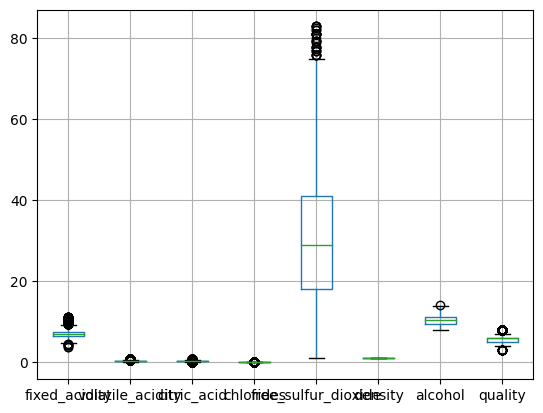

In [ ]:
#Remove outliers
df_c = df.loc[(stats.zscore(df) < 3).all(axis=1)]
df_c.boxplot()
plt.show()

In [ ]:
# Split indices for training, validation, and test sets
df_c = df_c.reset_index(drop=True)
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df_c))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (~20% test ~10% validation)
val_test_split = RandomSplitter(valid_pct=0.7)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

#Normalize
scaler = StandardScaler()
for feat in cont_names:
    df_c.loc[train_idx,feat] = scaler.fit_transform(df_c.loc[train_idx,[feat]])
    df_c.loc[val_idx,feat] = scaler.transform(df_c.loc[val_idx,[feat]])
    df_c.loc[test_idx,feat] = scaler.transform(df_c.loc[test_idx,[feat]])


# Create TabularPandas for training and validation
to = TabularPandas(
    df_c,
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)


# Create DataLoaders for training and validation
dls = to.dataloaders(bs=64, shuffle=True)

test_to = TabularPandas(
    df_c.iloc[test_idx],  # Select only the test data
    procs=[Categorify],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=64, shuffle=False)
dls.to(device)
test_dl.to(device)

In [ ]:
#Initialise arrays for the loops
layers = [[64], [64, 64], [ 64, 128, 256, 128, 64], [32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32] ]
n_layers=[1,2,5,11]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '11 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
metric = ['BalAcc']
init_weights = {}
for layer in n_layers:
  init_weights[layer] = {}

In [ ]:
#For each number of layers initialise the model with the same parameters.
for layer in layers:
  learn = tabular_learner(dls, layers=layer, n_out=10, metrics=utilsTFG.balanced_accuracy_func, loss_func=CrossEntropyLossFlat())
  learn.model.apply(utilsTFG.init_weights_glorot)
  learn.to(device)
  init_weights[len(layer)] = utilsTFG.get_params_from_model(learn.model)

  print(learn.summary())

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 1,240
Total trainable params: 1,240
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7cd7d66a4670>
Loss function: FlattenedLoss of CrossEntropyLoss()

Callbacks:
  - TrainEvalCallback
  - Cas

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
Linear                                    4096       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 10             
Linear                                    650        True      
____________________________________________________________________________

Total params: 5,464
Total train

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    448        True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       True      
ReLU                                                           
BatchNorm1d                               256        True      
____________________________________________________________________________
                     32 x 256            
Linear                                    32768      T

TabularModel (Input shape: 32 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 7              
BatchNorm1d                               14         True      
____________________________________________________________________________
                     32 x 32             
Linear                                    224        True      
ReLU                                                           
BatchNorm1d                               64         True      
____________________________________________________________________________
                     32 x 64             
Linear                                    2048       True      
ReLU                                                           
BatchNorm1d                               128        True      
____________________________________________________________________________
                     32 x 128            
Linear                                    8192       T

## Gradient Descent

In [ ]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}
time_gd = {}
epochs=20

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    time_gd[opt] = {}
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, n_out=10, loss_func=CrossEntropyLossFlat(), metrics=utilsTFG.balanced_accuracy_func, opt_func=opt2, cbs=[EarlyStoppingCallback(patience=3), SaveModelCallback()])
        learners[opt][len(layer)].to(device)
        learners[opt][len(layer)].model.to(device)
        utilsTFG.set_params_to_model(init_weights[len(layer)], learners[opt][len(layer)].model)


In [ ]:
#To check if the models have the same initial parameters
for layer in n_layers:
  if utilsTFG.compare_models(learners['NAG'][layer], learners['RMSProp'][layer]) and utilsTFG.compare_models(learners['NAG'][layer], learners['ADAM'][layer]) and utilsTFG.compare_models(learners['ADAM'][layer], learners['RMSProp'][layer]):
    print(f"Mismos parámetros en capa {layer}.")
  else:
    print("Distintos parámetros.")

Mismos parámetros en capa 1.
Mismos parámetros en capa 2.
Mismos parámetros en capa 5.
Mismos parámetros en capa 11.


### Nesterov

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.104162,1.023630,0.407205,00:01
1,1.123892,1.033831,0.402314,00:01
2,1.104097,1.028775,0.400119,00:01
3,1.137757,1.022656,0.412665,00:01
4,1.097589,1.040057,0.392765,00:01
5,1.103220,1.045676,0.394629,00:01
6,1.104587,1.043485,0.387781,00:01


Better model found at epoch 0 with valid_loss value: 1.0236295461654663.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 3 with valid_loss value: 1.022655963897705.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 3: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.077808,1.060326,0.405104,00:01
1,1.126944,1.048805,0.450456,00:01
2,1.119502,1.040408,0.428479,00:01
3,1.095385,1.097049,0.402205,00:01
4,1.094631,1.084638,0.440497,00:01
5,1.103417,1.022005,0.448515,00:01
6,1.089848,1.046649,0.406282,00:01
7,1.098033,1.081163,0.391367,00:01
8,1.099095,1.041932,0.446083,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 0 with valid_loss value: 1.060326337814331.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 1 with valid_loss value: 1.0488048791885376.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 2 with valid_loss value: 1.040407657623291.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 5 with valid_loss value: 1.022005319595337.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 5: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.194494,1.974357,0.350387,00:01
1,1.573362,1.439765,0.388521,00:01
2,1.243779,1.155970,0.405512,00:01
3,1.171361,1.051536,0.364179,00:01
4,1.121450,1.054543,0.415422,00:01
5,1.105713,1.037984,0.382052,00:01
6,1.098725,1.035953,0.443375,00:01
7,1.080886,1.026953,0.463382,00:01
8,1.083699,0.970857,0.445346,00:01
9,1.033915,1.012536,0.410292,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 1.9743565320968628.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 1 with valid_loss value: 1.4397650957107544.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 2 with valid_loss value: 1.1559700965881348.
Better model found at epoch 3 with valid_loss value: 1.0515358448028564.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 5 with valid_loss value: 1.0379836559295654.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 6 with valid_loss value: 1.035953164100647.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 7 with valid_loss value: 1.0269526243209839.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 8 with valid_loss value: 0.9708571434020996.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 8: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.261941,2.064267,0.291016,00:02
1,1.527559,1.249799,0.388317,00:04
2,1.245148,1.113721,0.343446,00:02
3,1.166631,1.074232,0.345116,00:02
4,1.143827,1.056157,0.362276,00:02
5,1.129217,1.013762,0.401433,00:03
6,1.098245,1.023253,0.353528,00:03
7,1.080582,1.009812,0.471211,00:02
8,1.088470,0.998003,0.430157,00:02
9,1.058141,0.993174,0.415814,00:02


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 2.0642669200897217.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 1 with valid_loss value: 1.2497994899749756.
Better model found at epoch 2 with valid_loss value: 1.1137205362319946.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 3 with valid_loss value: 1.0742322206497192.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 4 with valid_loss value: 1.056157112121582.
Better model found at epoch 5 with valid_loss value: 1.0137622356414795.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 7 with valid_loss value: 1.0098121166229248.
Better model found at epoch 8 with valid_loss value: 0.998003363609314.
Better model found at epoch 9 with valid_loss value: 0.9931737184524536.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 11 with valid_loss value: 0.9817402958869934.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 14 with valid_loss value: 0.9587786197662354.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 15 with valid_loss value: 0.9444282650947571.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 15: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

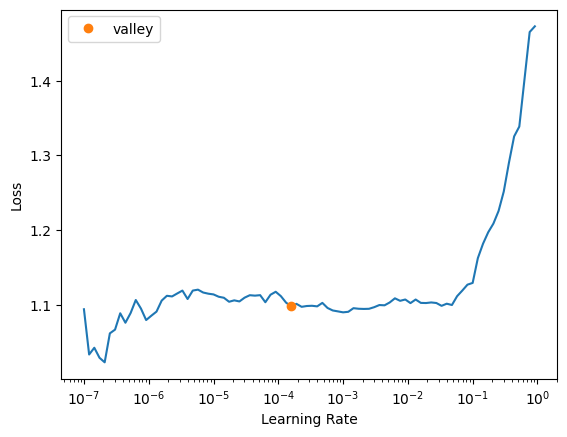

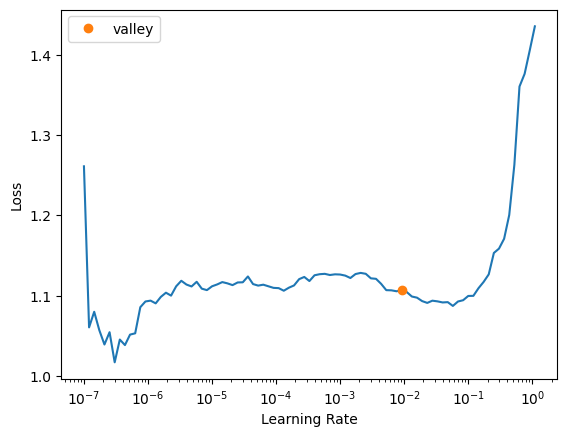

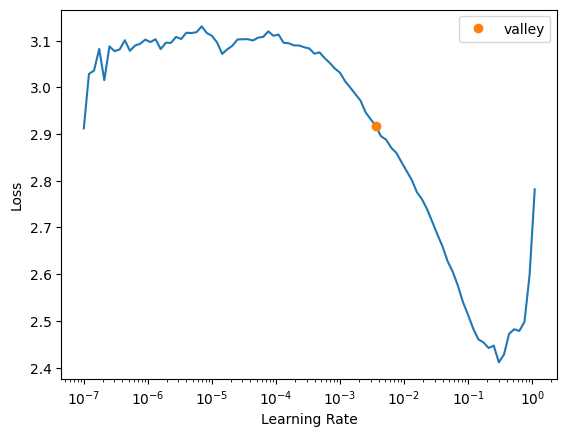

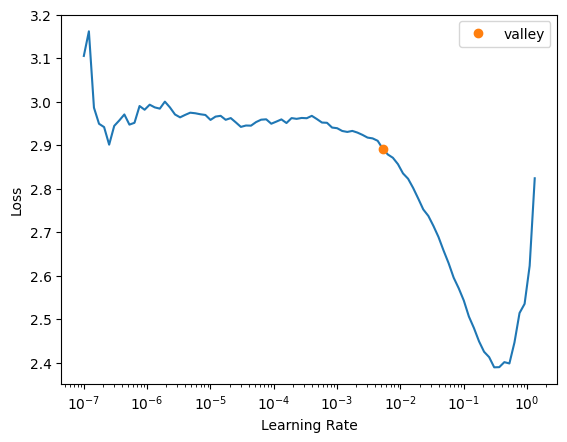

In [ ]:
#Run the training and measure the time for each layer
for layer, learner in learners['NAG'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['NAG'][layer] = end-start



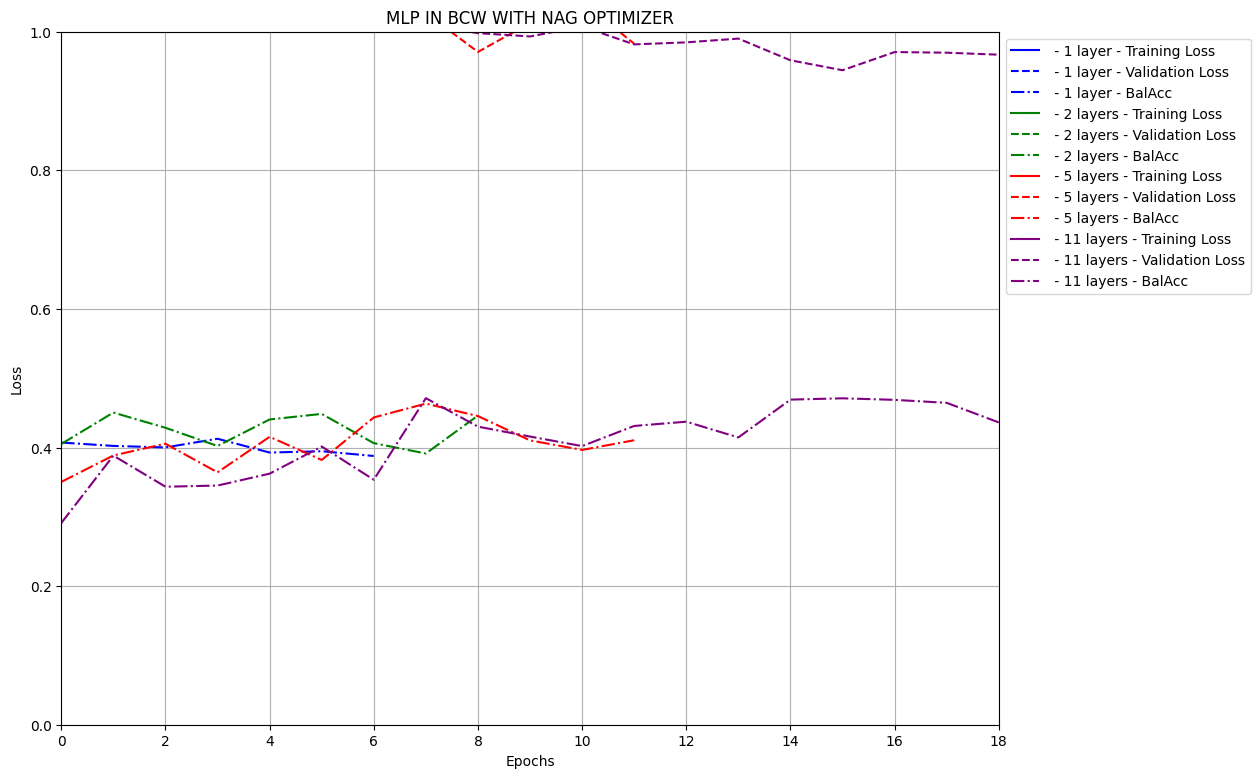

In [ ]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['NAG'].values(), title=f'MLP IN {plot_dataset} WITH NAG OPTIMIZER', names=names_layer, metric=metric)

### RMSProp

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.282603,1.073541,0.340072,00:01
1,1.185663,1.176364,0.343906,00:01
2,1.162109,1.143216,0.363698,00:01
3,1.124962,1.088220,0.351969,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 0 with valid_loss value: 1.0735408067703247.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 0: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.209366,1.306531,0.333989,00:01
1,1.172158,1.192773,0.378305,00:01
2,1.179368,1.089318,0.313437,00:01
3,1.102477,1.018031,0.333817,00:01
4,1.110117,1.142758,0.330681,00:01
5,1.144792,1.134180,0.362318,00:01
6,1.120729,1.145009,0.346520,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 1.3065311908721924.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 1 with valid_loss value: 1.1927728652954102.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 2 with valid_loss value: 1.0893183946609497.
Better model found at epoch 3 with valid_loss value: 1.0180306434631348.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 3: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.680677,1.441052,0.383735,00:01
1,1.223311,1.072401,0.416519,00:01
2,1.118123,1.163027,0.343460,00:01
3,1.116135,1.018971,0.391574,00:01
4,1.106714,1.031967,0.439214,00:01
5,1.108414,1.083209,0.344415,00:01
6,1.119585,1.156787,0.434568,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 1.4410524368286133.
Better model found at epoch 1 with valid_loss value: 1.0724010467529297.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 3 with valid_loss value: 1.0189710855484009.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 3: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,1.505219,1.133779,0.366762,00:03
1,1.229935,1.090819,0.324134,00:03
2,1.192134,1.094447,0.358703,00:03
3,1.155869,1.100311,0.345555,00:04
4,1.194493,1.077270,0.357704,00:03
5,1.160988,1.071599,0.337216,00:03
6,1.163313,1.032500,0.371521,00:03
7,1.150064,1.043061,0.357535,00:04
8,1.144279,1.056369,0.309245,00:03
9,1.135279,1.117808,0.326882,00:03


Better model found at epoch 0 with valid_loss value: 1.1337791681289673.
Better model found at epoch 1 with valid_loss value: 1.0908187627792358.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 4 with valid_loss value: 1.0772696733474731.
Better model found at epoch 5 with valid_loss value: 1.071599006652832.
Better model found at epoch 6 with valid_loss value: 1.0325003862380981.
No improvement since epoch 6: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

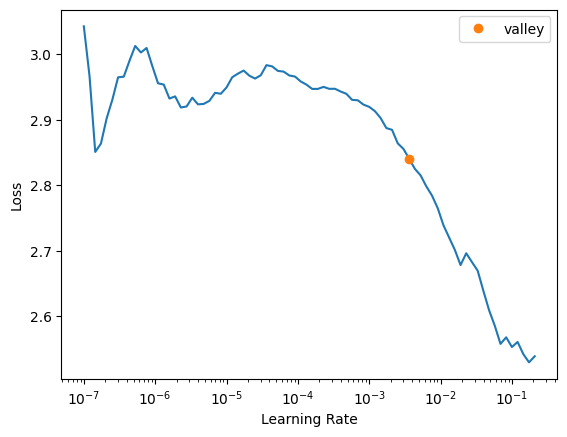

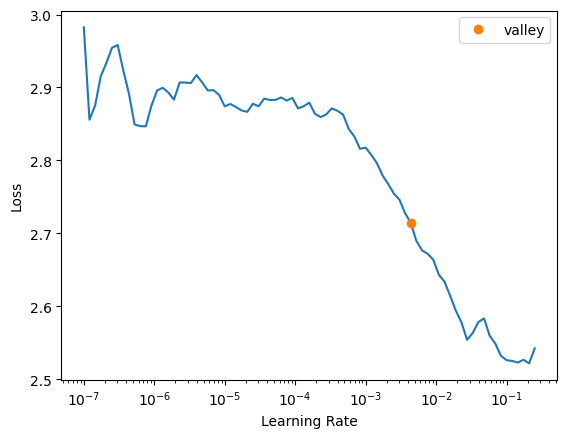

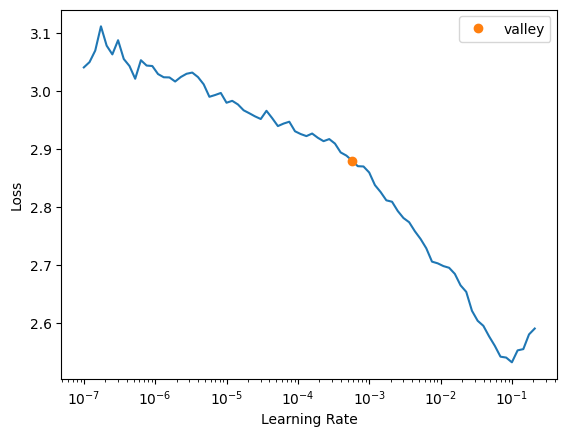

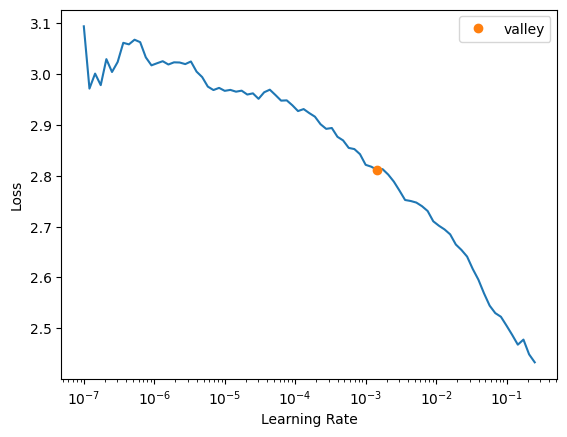

In [ ]:
#Run the training and measure the time for each layer
for layer, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['RMSProp'][layer] = end-start


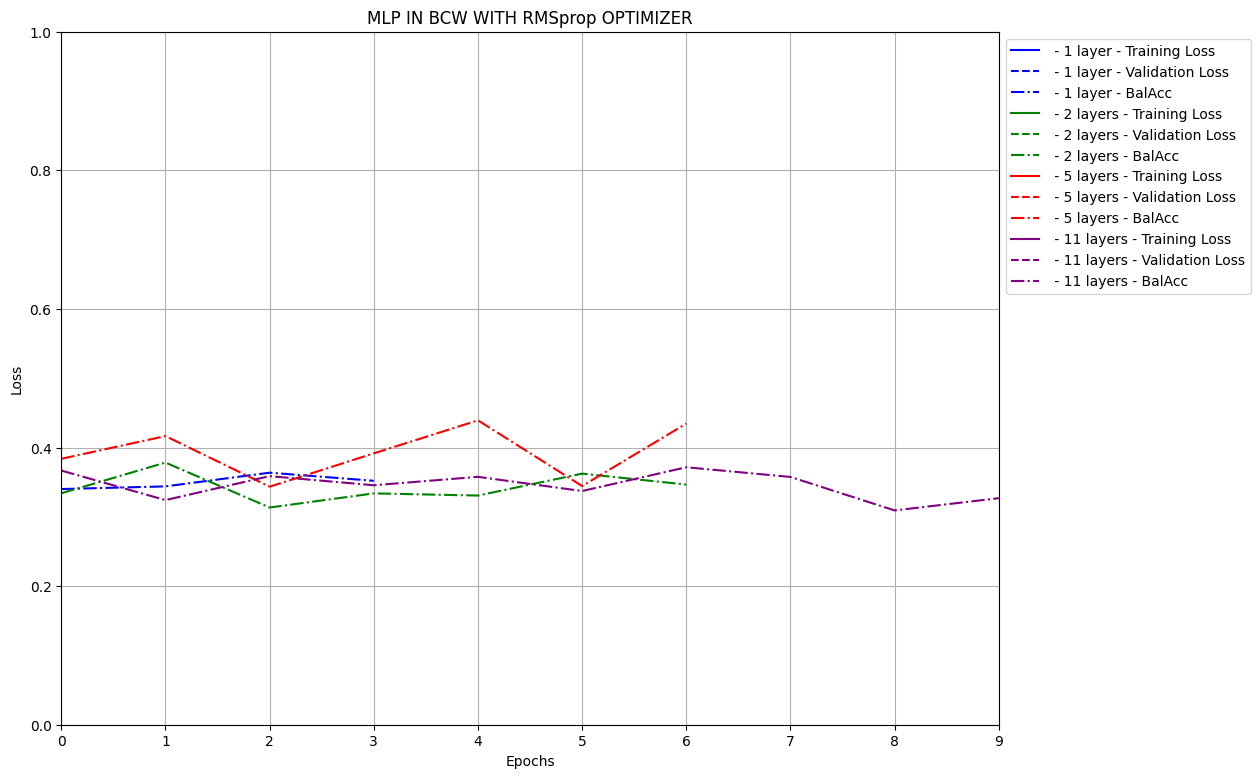

In [ ]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title=f'MLP IN {plot_dataset} WITH RMSprop OPTIMIZER', names=names_layer, metric=metric)

### Adam

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.619416,2.878955,0.170872,00:01
1,2.037348,2.064995,0.337428,00:01
2,1.467757,1.259742,0.361919,00:01
3,1.198265,1.132324,0.361318,00:01
4,1.168180,1.091934,0.353222,00:01
5,1.135688,1.091629,0.374984,00:01
6,1.126236,1.052308,0.378967,00:01
7,1.092416,1.076816,0.367862,00:01
8,1.091108,1.039149,0.390553,00:01
9,1.088483,1.039831,0.385057,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 2.8789548873901367.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 1 with valid_loss value: 2.0649948120117188.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 2 with valid_loss value: 1.2597423791885376.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 3 with valid_loss value: 1.1323237419128418.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 4 with valid_loss value: 1.0919338464736938.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 5 with valid_loss value: 1.0916287899017334.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 6 with valid_loss value: 1.052308201789856.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 8 with valid_loss value: 1.0391490459442139.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 11 with valid_loss value: 1.0325547456741333.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 13 with valid_loss value: 1.02740478515625.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 16 with valid_loss value: 1.0166922807693481.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 18 with valid_loss value: 1.0153186321258545.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.094714,2.078977,0.327814,00:01
1,1.459725,1.181520,0.391296,00:01
2,1.182027,1.146119,0.371133,00:01
3,1.150366,1.067829,0.385604,00:01
4,1.114162,1.024628,0.439391,00:01
5,1.124179,1.121045,0.448233,00:01
6,1.096967,1.023922,0.419001,00:01
7,1.115973,1.099061,0.391261,00:01
8,1.082363,1.032269,0.348218,00:01
9,1.076189,1.053086,0.448924,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 2.078977108001709.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 1 with valid_loss value: 1.181519865989685.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 2 with valid_loss value: 1.1461185216903687.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 3 with valid_loss value: 1.06782865524292.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 4 with valid_loss value: 1.0246278047561646.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 6 with valid_loss value: 1.023922085762024.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 6: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.195669,1.913549,0.398092,00:01
1,1.692209,1.503242,0.371722,00:01
2,1.270847,1.241178,0.382868,00:01
3,1.126912,1.046731,0.420892,00:01
4,1.125264,1.074386,0.368504,00:02
5,1.129056,1.040353,0.401227,00:02
6,1.074138,1.003950,0.423720,00:01
7,1.079357,1.039413,0.385118,00:01
8,1.077162,1.045260,0.444094,00:01
9,1.053310,1.081569,0.446983,00:01


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 1.9135493040084839.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 1 with valid_loss value: 1.5032422542572021.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 2 with valid_loss value: 1.241178035736084.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 3 with valid_loss value: 1.0467312335968018.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 5 with valid_loss value: 1.0403530597686768.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 6 with valid_loss value: 1.0039496421813965.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 6: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,balanced_accuracy_func,time
0,2.169582,2.215871,0.308206,00:04
1,1.706294,1.463953,0.360013,00:04
2,1.246510,1.075003,0.383744,00:04
3,1.133237,1.046434,0.332029,00:04
4,1.112367,1.084869,0.323189,00:04
5,1.094644,1.008865,0.371960,00:03
6,1.116708,1.036634,0.363946,00:03
7,1.090450,1.008376,0.419154,00:04
8,1.117169,1.009264,0.395978,00:03
9,1.091432,0.991578,0.368873,00:03


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Better model found at epoch 0 with valid_loss value: 2.2158706188201904.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 1 with valid_loss value: 1.4639527797698975.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 2 with valid_loss value: 1.0750033855438232.
Better model found at epoch 3 with valid_loss value: 1.0464340448379517.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Better model found at epoch 5 with valid_loss value: 1.0088645219802856.
Better model found at epoch 7 with valid_loss value: 1.0083755254745483.
Better model found at epoch 9 with valid_loss value: 0.9915782809257507.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

No improvement since epoch 9: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

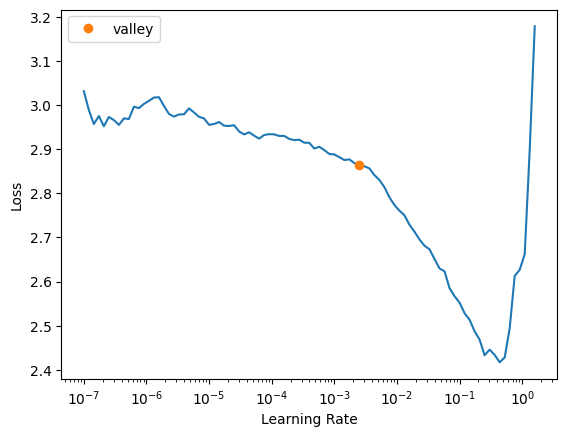

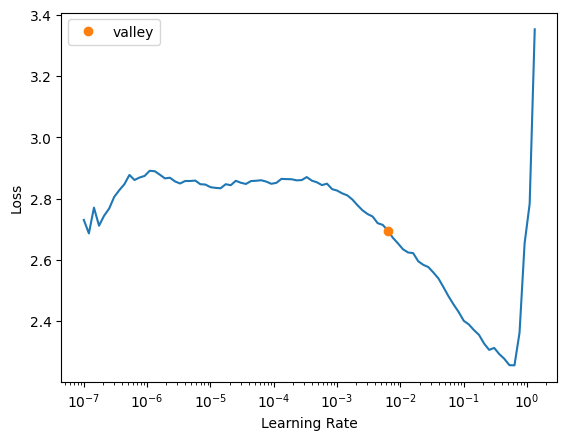

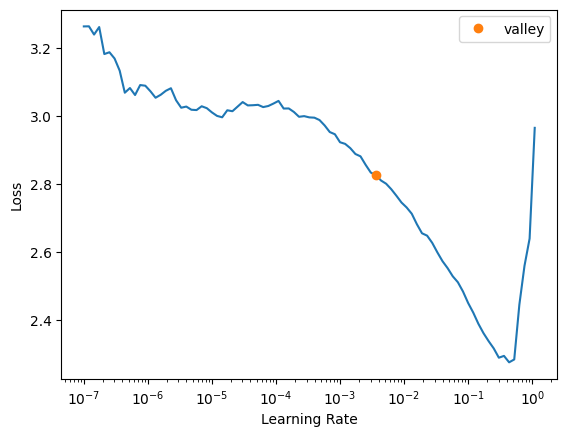

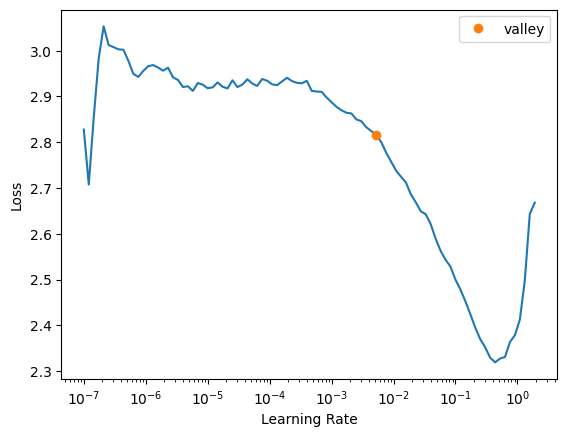

In [ ]:
#Run the training and measure the time for each layer
for layer, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  start = time.perf_counter()
  learner.fit_one_cycle(epochs, lr)
  end = time.perf_counter()
  time_gd['ADAM'][layer] = end-start


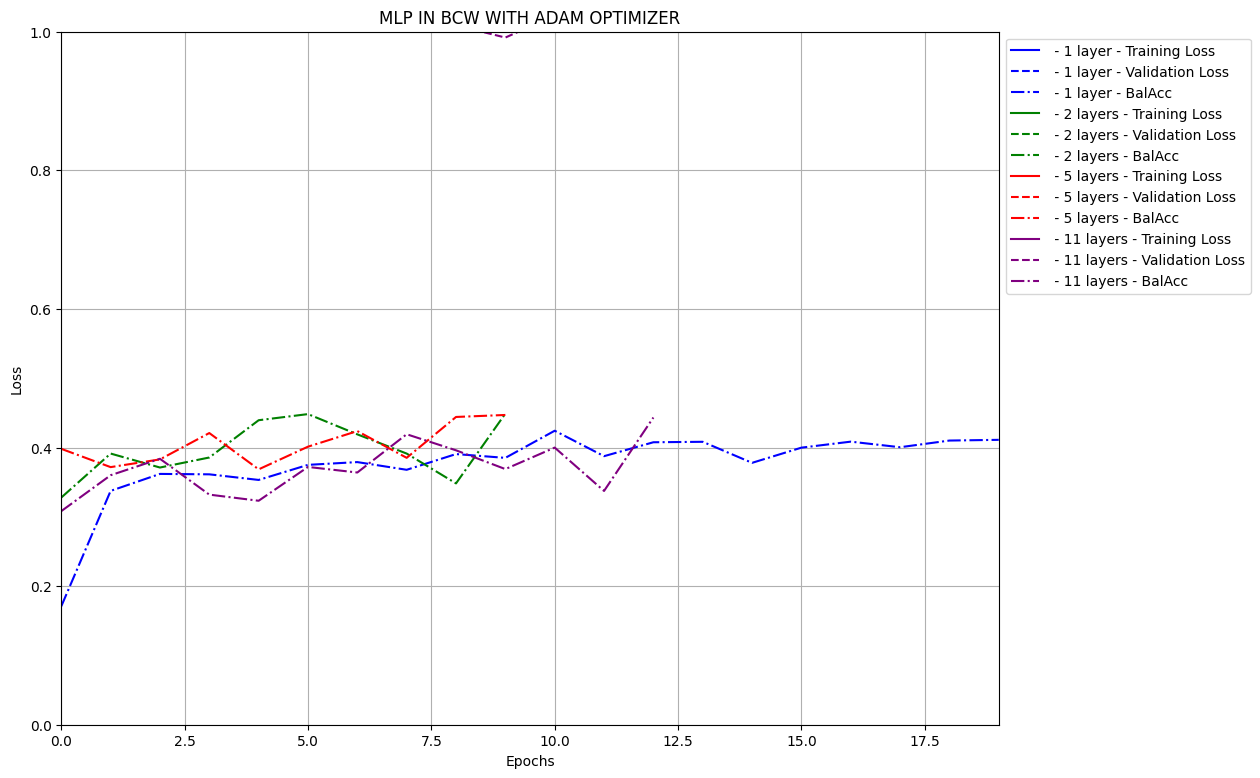

In [ ]:
#Plot the grafic for all layers combined
utilsTFG.plot_learners_training(learners['ADAM'].values(), title=f'MLP IN {plot_dataset} WITH ADAM OPTIMIZER', names=names_layer, metric=metric)

### Save or Load models

In [ ]:
#Save learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/content/drive/MyDrive/learners/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump({'learner': learners[optim][layer], 'recorder_values': learners[optim][layer].recorder.values}, f)


In [ ]:
#Load learner with their losses and metrics
for optim in optims:
  for layer in n_layers:
    file_path = f'/content/drive/MyDrive/learners/saved_models/learner_{dataset}_{layer}_{optim}.pkl'
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    learners[optim][layer], learners[optim][layer].recorder.values = data['learner'], data['recorder_values']

### Comparative per layers

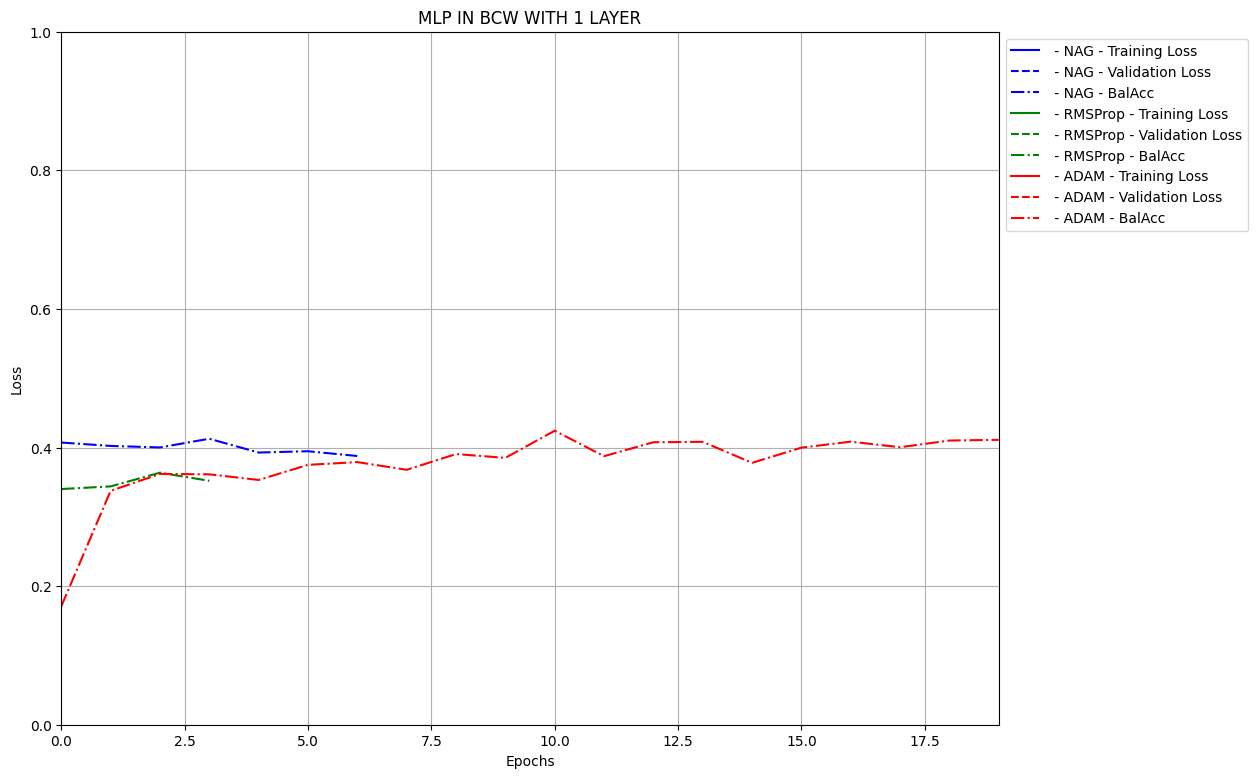

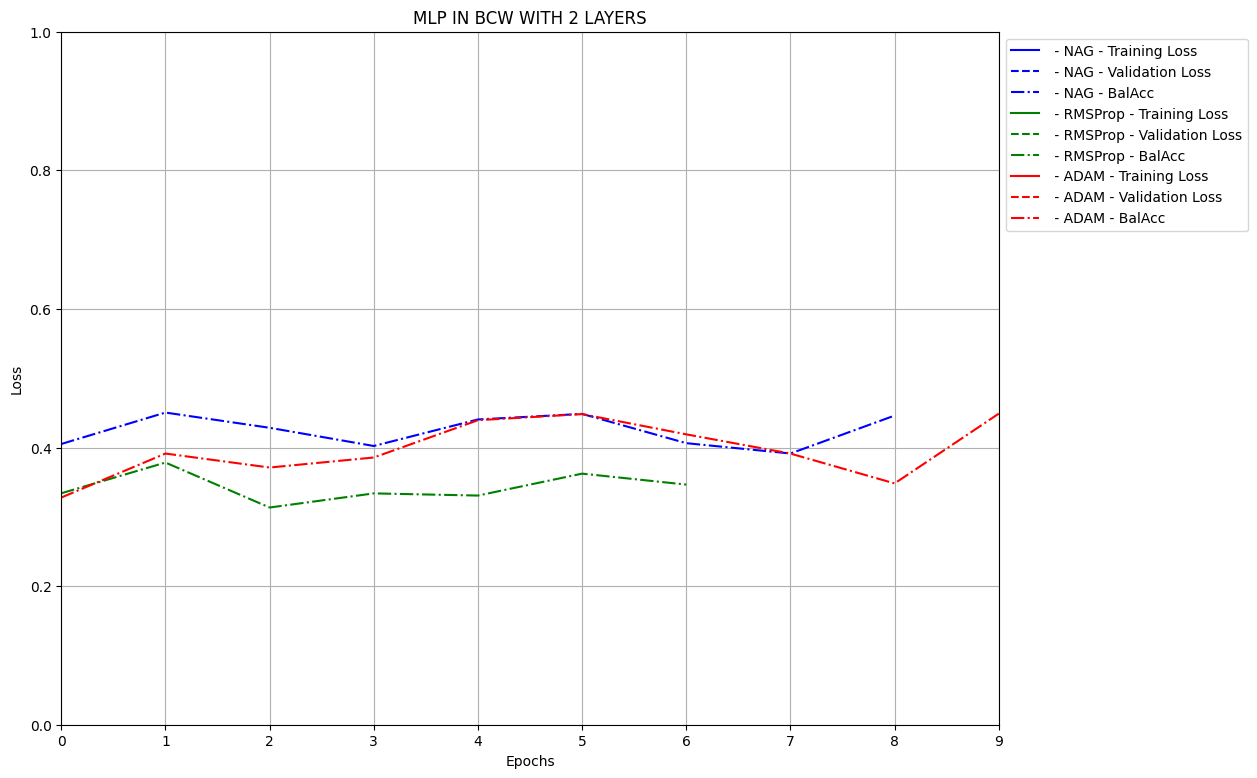

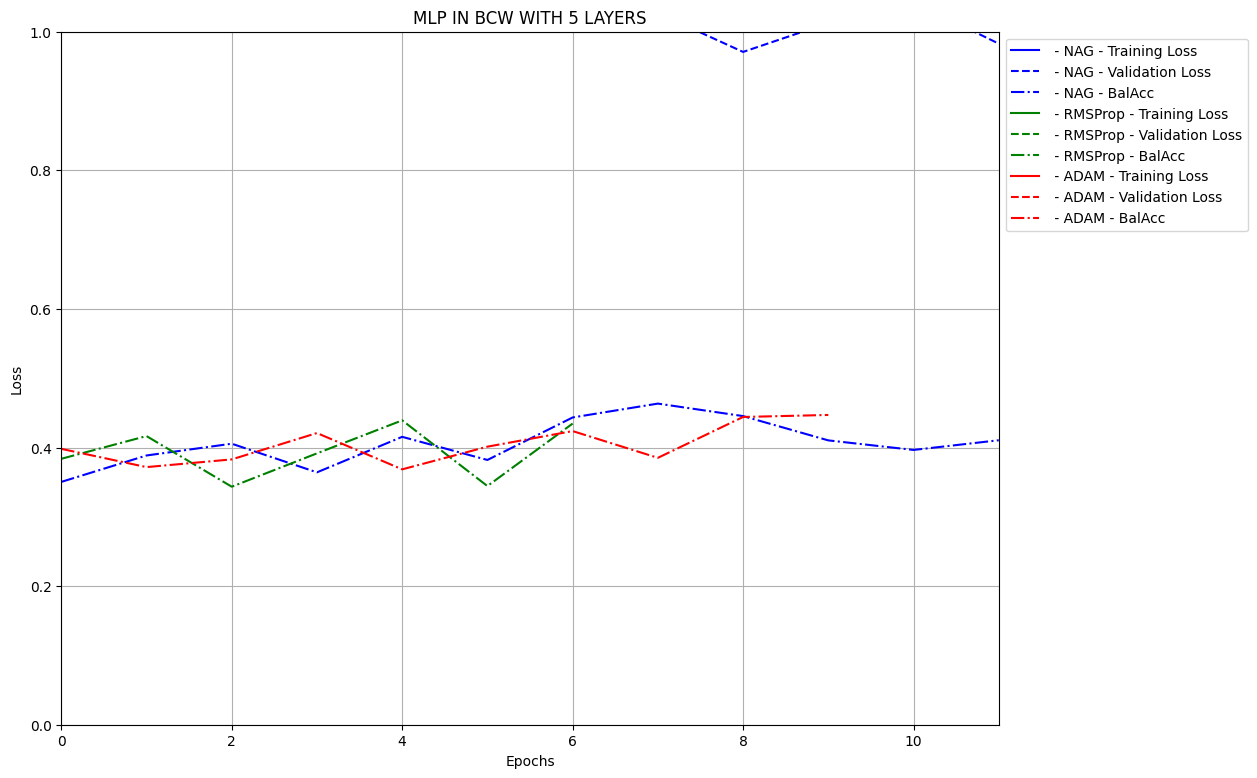

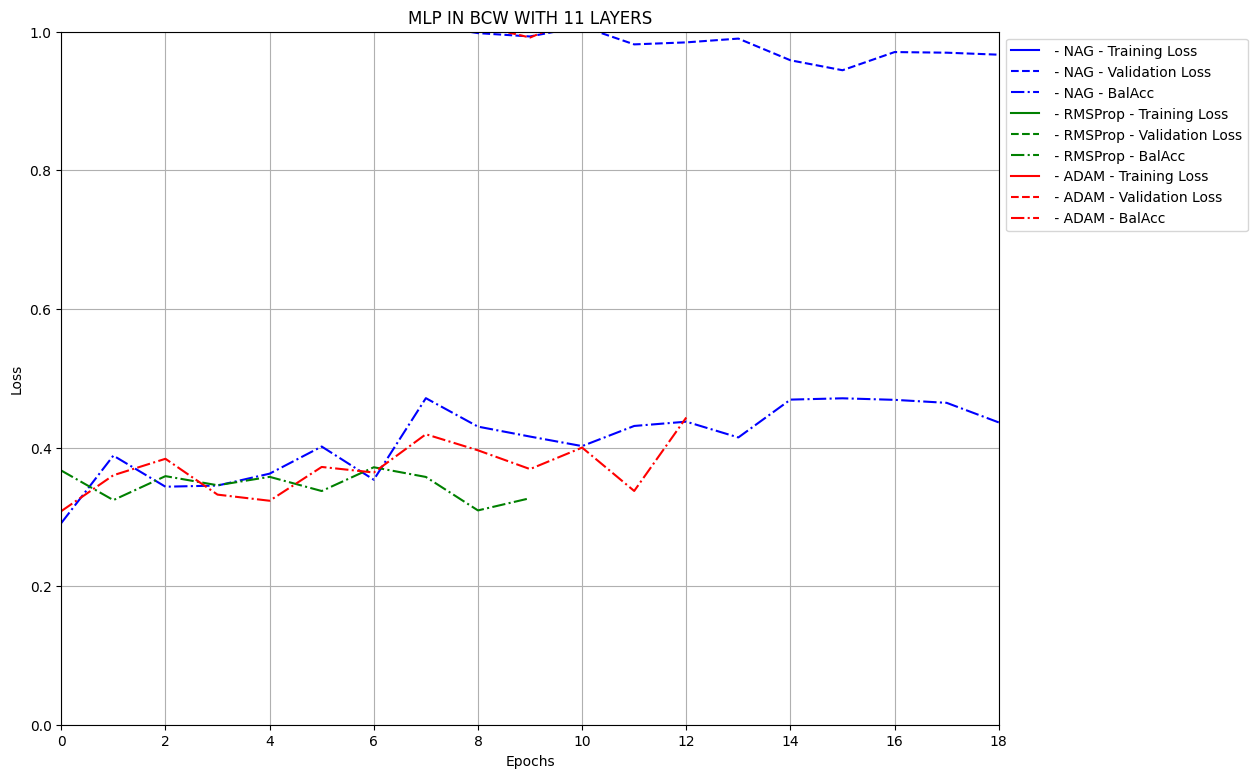

In [ ]:
#Compare the three optimizers for each layer

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_11_layers = [learners['NAG'][11], learners['RMSProp'][11], learners['ADAM'][11]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title=f'MLP IN {plot_dataset} WITH 1 LAYER', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_2_layers, title=f'MLP IN {plot_dataset} WITH 2 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_5_layers, title=f'MLP IN {plot_dataset} WITH 5 LAYERS', names=names, metric=metric)
utilsTFG.plot_learners_training(learners_11_layers, title=f'MLP IN {plot_dataset} WITH 11 LAYERS', names=names, metric=metric)

### Generalization

In [ ]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate bal_accuracy
    accuracy = utilsTFG.balanced_accuracy_func(preds, targs)

    #Calculate loss
    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Balanced Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Optimizer: NAG, Layers: 1, Loss: 1.2703320980072021, Balanced Accuracy: 0.2082648721405732


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Optimizer: NAG, Layers: 2, Loss: 1.3501853942871094, Balanced Accuracy: 0.19713399540848175


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Optimizer: NAG, Layers: 5, Loss: 1.350804090499878, Balanced Accuracy: 0.20469087976289468


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Optimizer: NAG, Layers: 11, Loss: 1.2772464752197266, Balanced Accuracy: 0.19630455193896731


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Optimizer: RMSProp, Layers: 1, Loss: 1.2882411479949951, Balanced Accuracy: 0.19855454926459107


Optimizer: RMSProp, Layers: 2, Loss: 1.338350534439087, Balanced Accuracy: 0.21392235789575773


Optimizer: RMSProp, Layers: 5, Loss: 1.269188404083252, Balanced Accuracy: 0.19827863178567548


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Optimizer: RMSProp, Layers: 11, Loss: 1.3273261785507202, Balanced Accuracy: 0.18839305536265438


Optimizer: ADAM, Layers: 1, Loss: 1.2761904001235962, Balanced Accuracy: 0.20458191409451457


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Optimizer: ADAM, Layers: 2, Loss: 1.3366037607192993, Balanced Accuracy: 0.20882013838791194


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/sklearn/metrics

Optimizer: ADAM, Layers: 5, Loss: 1.3339433670043945, Balanced Accuracy: 0.19334988080663748


Optimizer: ADAM, Layers: 11, Loss: 1.2620527744293213, Balanced Accuracy: 0.19698137443802186


## Metaheuristics

In [ ]:
#Initialise dictionaries
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}
time_mh = {}

#Initialise the population to have the same values for all the MH
for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  fitness[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, n_out=10, loss_func=CrossEntropyLossFlat(), layers=layer, cbs=[SaveModelCallback()])
  mh_learners[n_layer].to(device)
  mh_learners[n_layer].model.to(device)
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.init_weights_glorot)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

    fitness[n_layer].append(utilsTFG.err_param_w_model(model_copy, dls))

#More initialisation
for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}
  time_mh[alg] = {}

max_evals=4200
max_evals_shade=200
max_ls=10


### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
#results['GA'] = {}
#for layer in n_layers:
#  start = time.perf_counter()
#  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), fitness[layer], dls, 4000, mh_learners[layer])
#  end = time.perf_counter()
#  time_mh['GA'][layer] = end-start

### SHADE

In [ ]:
#Runing SHADE algorithm

results['SHADE'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), pop_size,max_evals, len(population[layer][0]), dls,  model=mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE'][layer] = end-start


In [ ]:
#Validate the models obtained.
fitness_valid['SHADE'] = {}
for layer in n_layers:
  fitness_valid['SHADE'][layer] = []
  for ind in results['SHADE'][layer][5]:
    fitness_valid['SHADE'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#compare train and valid and select the best generalizing model.
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][6]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = np.array(fitness_valid['SHADE'][layer]) - np.array(results['SHADE'][layer][6])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE'][layer])
  best['SHADE'][layer] = results['SHADE'][layer][5][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")

  print("\n")

Training error of SHADE for 1 layers: [2.6908838748931885, 2.5859224796295166, 2.4940643310546875]
Validation error of SHADE for 1 layers: [22.64524269104004, 34.48436737060547, 21.68474578857422]
Difference: [19.95435882 31.89844489 19.19068146]
Best generalizing model: Model 3 (1-10)


Training error of SHADE for 2 layers: [2.751622200012207, 2.7291100025177, 2.603300094604492]
Validation error of SHADE for 2 layers: [41.47053527832031, 41.47053527832031, 24.927000045776367]
Difference: [38.71891308 38.74142528 22.32369995]
Best generalizing model: Model 3 (1-10)


Training error of SHADE for 5 layers: [2.812849998474121, 2.7071707248687744, 2.7021572589874268]
Validation error of SHADE for 5 layers: [4.323877811431885, 5.989967346191406, 3.43053936958313]
Difference: [1.51102781 3.28279662 0.72838211]
Best generalizing model: Model 3 (1-10)


Training error of SHADE for 11 layers: [2.834784984588623, 2.6552863121032715, 2.604548692703247]
Validation error of SHADE for 11 layers: [2.

### SHADE-ILS

In [ ]:
# Running SHADE-ILS algorithm
results['SHADE-ILS'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS'][layer] = end-start


eo
deque([1, 0.5466495693705292, 0.004947439139091453], maxlen=3)
deque([0.5466495693705292, 0.004947439139091453, 0.026082257182885638], maxlen=3)
74
eo
deque([0.004947439139091453, 0.026082257182885638, 0.0], maxlen=3)
deque([0.026082257182885638, 0.0, -0.0051296959400763745], maxlen=3)
Reiniciado
146
eo
deque([1, 0.5223925886004329, 0.0], maxlen=3)
deque([0.5223925886004329, 0.0, 0.03640187266855269], maxlen=3)
79
eo
deque([0.0, 0.03640187266855269, 0.0023150789177107255], maxlen=3)
deque([0.03640187266855269, 0.0023150789177107255, -0.004526450338452956], maxlen=3)
Reiniciado
147
eo
deque([1, 0.5643312294646493, 0.010786483845566073], maxlen=3)
deque([0.5643312294646493, 0.010786483845566073, 0.018419311031152186], maxlen=3)
82
eo
deque([0.010786483845566073, 0.018419311031152186, 0.0], maxlen=3)
deque([0.018419311031152186, 0.0, -0.0010869780827149247], maxlen=3)
Reiniciado
159
eo
deque([1, 0.5652115021509763, 0.0], maxlen=3)
deque([0.5652115021509763, 0.0, 0.07984919955814879], m

In [ ]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS'][layer]) - np.array(results['SHADE-ILS'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS'][layer])
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS for 1 layers: [2.6908838748931885, 1.219913363456726, 1.1822172403335571, 1.1822172403335571]
Validation error of SHADE-ILS for 1 layers: [42.72444534301758, 42.634464263916016, 40.880943298339844, 40.880943298339844]
Difference: [40.03356147 41.4145509  39.69872606 39.69872606]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-ILS for 2 layers: [2.751622200012207, 1.314195156097412, 1.2663559913635254, 1.2663559913635254]
Validation error of SHADE-ILS for 2 layers: [56.828704833984375, 19.503761291503906, 19.77365493774414, 19.77365493774414]
Difference: [54.07708263 18.18956614 18.50729895 18.50729895]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS for 5 layers: [2.812849998474121, 1.2254709005355835, 1.1899235248565674, 1.1899235248565674]
Validation error of SHADE-ILS for 5 layers: [7.965800762176514, 21.87810516357422, 20.88863182067871, 20.88863182067871]
Difference: [ 5.15295076 20.65263426 19.6987083  19.6987083

### SHADE-GD

In [ ]:
# Running SHADE algorithm with GD
results['SHADE-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-GD'][layer] = utilsTFG.SHADE_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)
  end = time.perf_counter()
  time_mh['SHADE-GD'][layer] = end-start


eo
deque([1, 1, 0.03900628943634299], maxlen=3)
deque([1, 1, 0.03900628943634299], maxlen=3)
eo
deque([1, 0.03900628943634299, 0.016922325858634565], maxlen=3)
deque([1, 0.03900628943634299, 0.016922325858634565], maxlen=3)
eo
deque([1, 1, 0.008181427484633234], maxlen=3)
deque([1, 1, 0.008181427484633234], maxlen=3)
eo
deque([1, 0.008181427484633234, 0.02169670133366624], maxlen=3)
deque([1, 0.008181427484633234, 0.02169670133366624], maxlen=3)
eo
deque([1, 1, 0.039352521302857074], maxlen=3)
deque([1, 1, 0.039352521302857074], maxlen=3)
eo
deque([1, 0.039352521302857074, 0.019793060834933505], maxlen=3)
deque([1, 0.039352521302857074, 0.019793060834933505], maxlen=3)
eo
deque([1, 1, 0.06332003078229934], maxlen=3)
deque([1, 1, 0.06332003078229934], maxlen=3)
eo
deque([1, 0.06332003078229934, 0.03195173814891123], maxlen=3)
deque([1, 0.06332003078229934, 0.03195173814891123], maxlen=3)


In [ ]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-GD'][layer]) - np.array(results['SHADE-GD'][layer][2])
  print(f"Difference: {dif}")
  #mejor = np.argmin(dif)
  mejor = np.argmin(fitness_valid['SHADE-GD'][layer])
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-GD for 1 layers: [2.6908838748931885, 2.5859224796295166, 2.5421626567840576]
Validation error of SHADE-GD for 1 layers: [42.72444534301758, 37.11503982543945, 31.42816925048828]
Difference: [40.03356147 34.52911735 28.88600659]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-GD for 2 layers: [2.751622200012207, 2.7291100025177, 2.6698973178863525]
Validation error of SHADE-GD for 2 layers: [56.828704833984375, 56.69961929321289, 21.18150520324707]
Difference: [54.07708263 53.97050929 18.51160789]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-GD for 5 layers: [2.812849998474121, 2.7021572589874268, 2.6486732959747314]
Validation error of SHADE-GD for 5 layers: [7.965800762176514, 4.497273921966553, 3.384695053100586]
Difference: [5.15295076 1.79511666 0.73602176]
Best generalizing model: Model 3 (1-10)


Training error of SHADE-GD for 11 layers: [2.834784984588623, 2.6552863121032715, 2.5704452991485596]
Validation error of 

### SHADE-ILS-GD

In [ ]:
# SHADE-ILS-GD
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  start = time.perf_counter()
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS_GD(copy.deepcopy(population[layer]), copy.deepcopy(fitness[layer]),  max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)
  end = time.perf_counter()
  time_mh['SHADE-ILS-GD'][layer] = end-start


deque([1, 1, 0.5679539994426913], maxlen=3)
eo
deque([1, 0.5679539994426913, 0.0], maxlen=3)
deque([0.5679539994426913, 0.0, -0.010844324133104674], maxlen=3)
deque([0.0, -0.010844324133104674, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.45495700727022265], maxlen=3)
deque([1, 0.45495700727022265, 0.40677958039507506], maxlen=3)
deque([0.45495700727022265, 0.40677958039507506, 0.0], maxlen=3)
deque([1, 1, 0.5810515252392745], maxlen=3)
eo
deque([1, 0.5810515252392745, 0.0013153695764530646], maxlen=3)
deque([0.5810515252392745, 0.0013153695764530646, 0.0109736759759136], maxlen=3)
deque([0.0013153695764530646, 0.0109736759759136, 0.0], maxlen=3)
Reiniciado
eo
deque([1, 1, 0.34972732735786816], maxlen=3)
deque([1, 0.34972732735786816, 0.4793337384463373], maxlen=3)
deque([0.34972732735786816, 0.4793337384463373, 0.0], maxlen=3)
deque([1, 1, 0.5736616231907447], maxlen=3)
eo
deque([1, 0.5736616231907447, 0.0], maxlen=3)
deque([0.5736616231907447, 0.0, 0.022408615806460464], maxlen=3)
de

In [ ]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = np.array(fitness_valid['SHADE-ILS-GD'][layer]) - np.array(results['SHADE-ILS-GD'][layer][2])
  print(f"Difference: {dif}")
  mejor = np.argmin(fitness_valid['SHADE-ILS-GD'][layer])
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][3][mejor]
  print(f"Best generalizing model: Model {mejor+1} (1-10)")
  print("\n")

Training error of SHADE-ILS-GD for 1 layers: [2.6908838748931885, 1.1625856161117554, 1.1751930713653564, 1.1751930713653564]
Validation error of SHADE-ILS-GD for 1 layers: [42.72444534301758, 41.22376251220703, 42.03530502319336, 42.03530502319336]
Difference: [40.03356147 40.0611769  40.86011195 40.86011195]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS-GD for 2 layers: [2.751622200012207, 1.1527879238128662, 1.138637900352478, 1.138637900352478]
Validation error of SHADE-ILS-GD for 2 layers: [56.828704833984375, 19.950204849243164, 20.73914337158203, 20.73914337158203]
Difference: [54.07708263 18.79741693 19.60050547 19.60050547]
Best generalizing model: Model 2 (1-10)


Training error of SHADE-ILS-GD for 5 layers: [2.812849998474121, 1.199225902557373, 1.172352910041809]
Validation error of SHADE-ILS-GD for 5 layers: [7.965800762176514, 19.923683166503906, 21.016660690307617]
Difference: [ 5.15295076 18.72445726 19.84430778]
Best generalizing model: Model 1 

### Save or load

In [ ]:
#Save the mh results
file_path = f'/content/drive/MyDrive/learners/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
#Load the trained mh results
file_path = f'/content/drive/MyDrive/learners/saved_models/mh_dict_{dataset}.pkl'
with open(file_path, 'rb') as f:
    results = pickle.load(f)

### Comparison between MH

In [ ]:
#Saving training loss for better manipulation
training = {}
for mh in algs:
  training[mh] = {}
for layer in n_layers:
  training['SHADE'][layer] = results['SHADE'][layer][6]
  training['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2]
  training['SHADE-GD'][layer] = results['SHADE-GD'][layer][2]
  training['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][2]

In [ ]:
#Calculate accuracy and balanced accuracy
bal_acc = {}
for mh in algs:
  bal_acc[mh] = {}
  for layer in n_layers:
    bal_acc[mh][layer] = []
    ind = 5 if mh == 'SHADE' else 3
    for model in results[mh][layer][ind]:
      utilsTFG.set_params_to_model(model, mh_learners[layer].model)
      mh_learners[layer].model.eval()
      mh_learners[layer].eval()
      preds, targs = mh_learners[layer].get_preds(dl=dls.valid)
      targs = targs.long().squeeze()

      # Calculate balanced_accuracy
      bal_acc[mh][layer].append(utilsTFG.balanced_accuracy_func(preds, targs))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


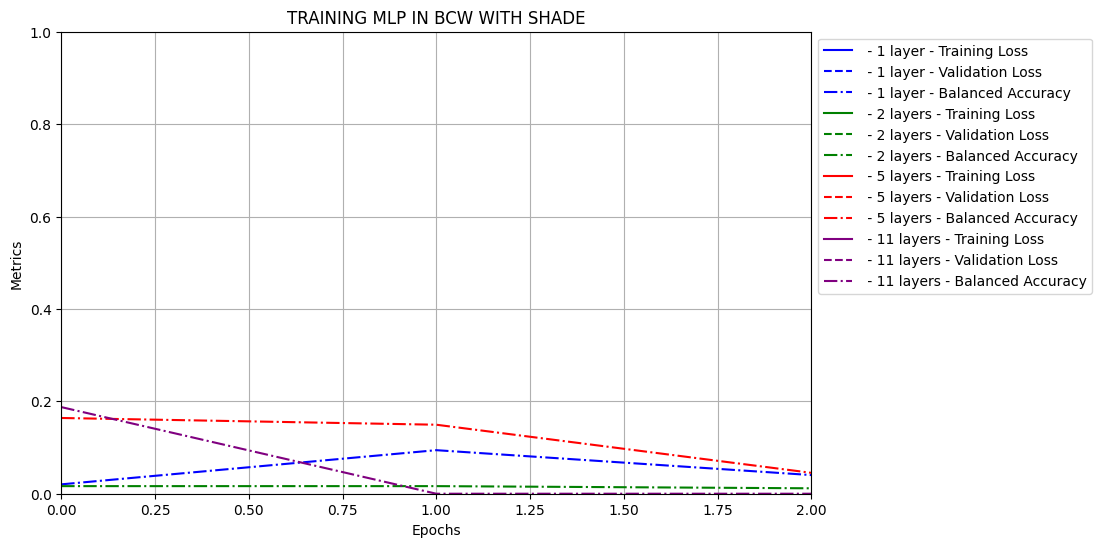

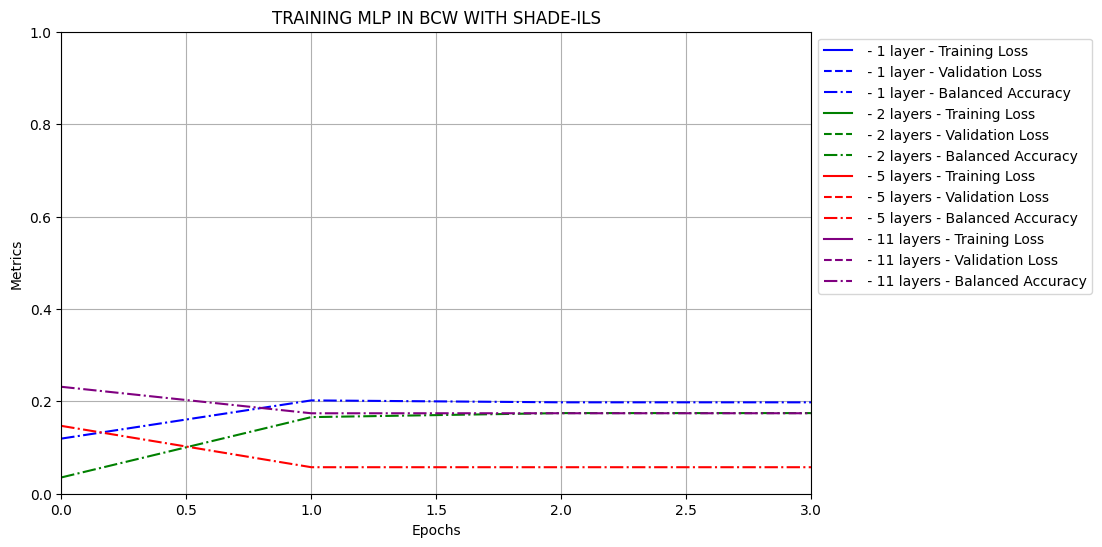

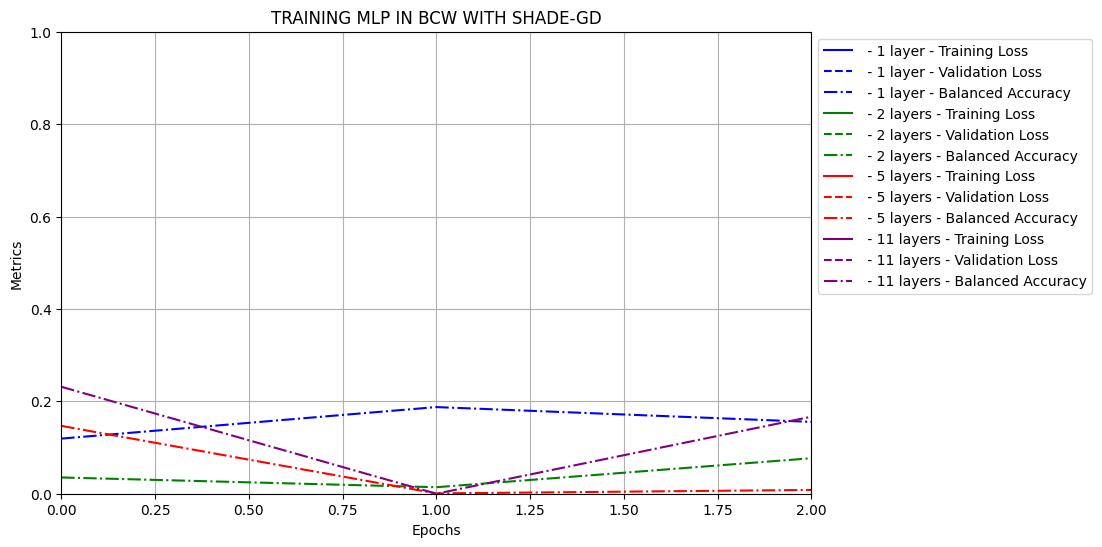

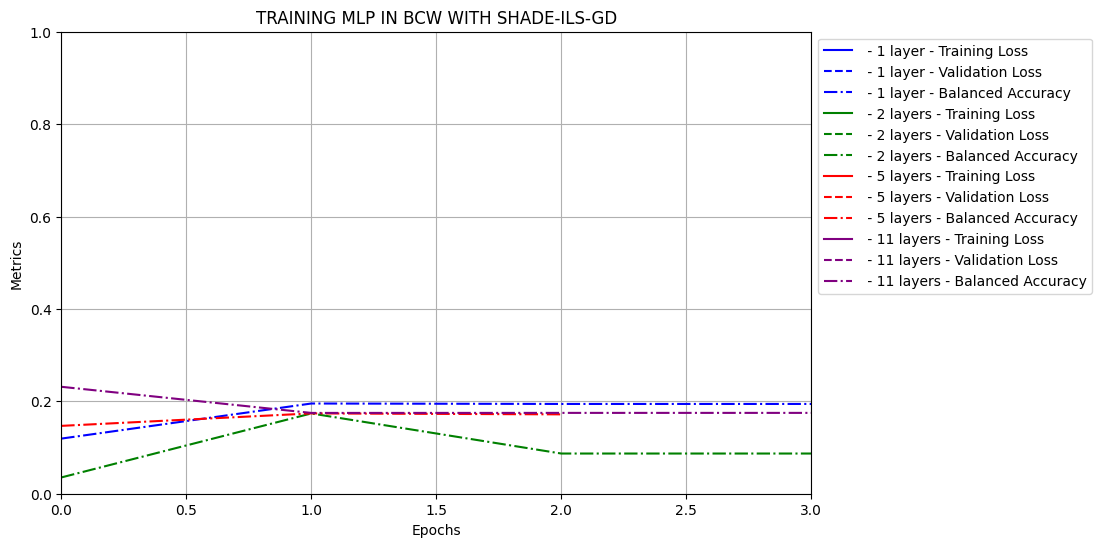

In [ ]:
#Comparing the different layers version of the same MH
names= ['1 layer', '2 layers', '5 layers', '11 layers']
for alg in algs:
  utilsTFG.plot_mh_mlp_training(training[alg], fitness_valid[alg], bal_acc[alg],  layers = n_layers, names=names, title=f'TRAINING MLP IN BCW WITH {alg}')

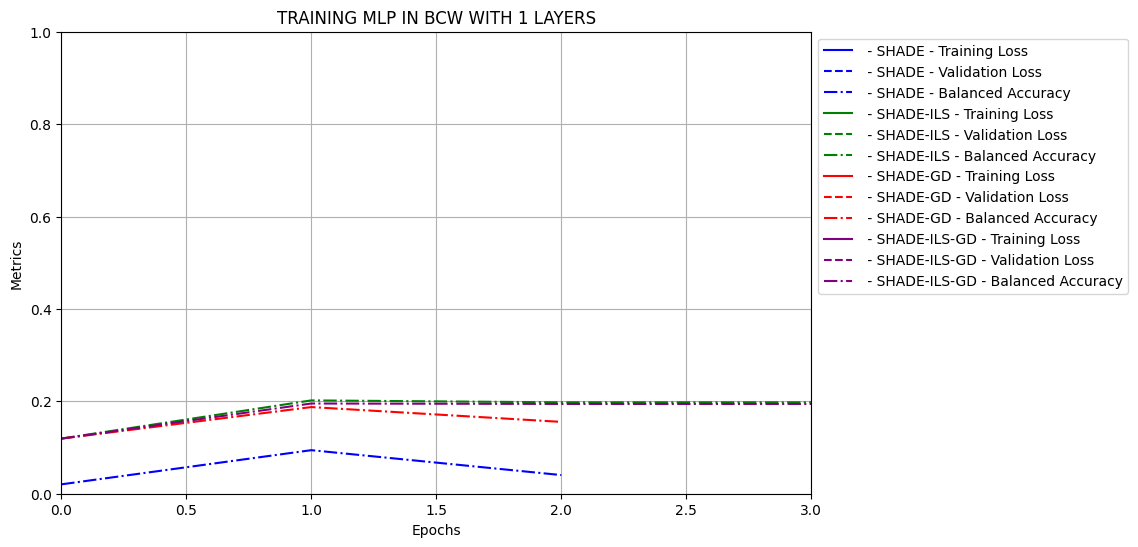

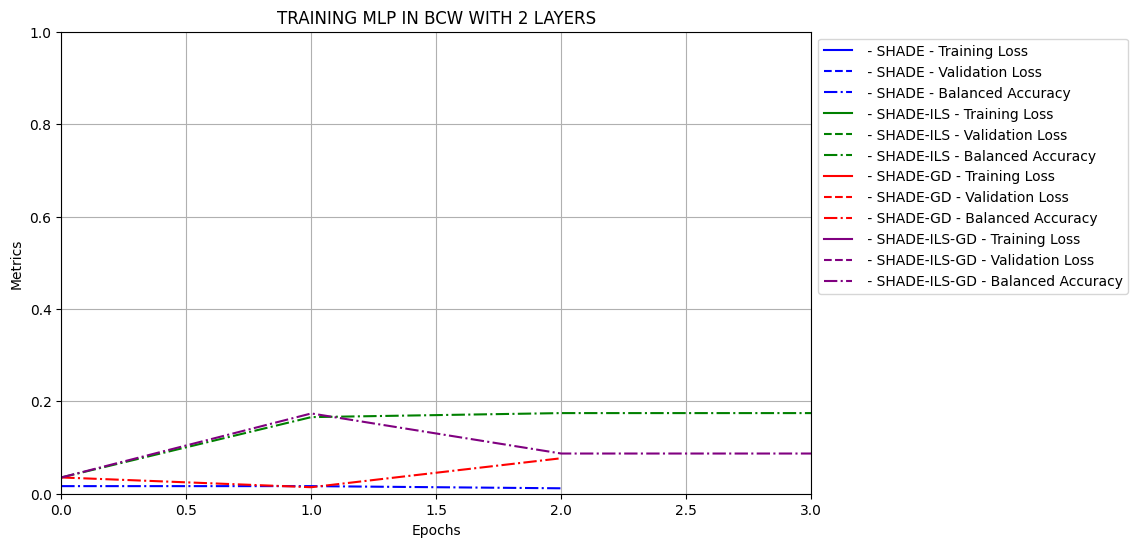

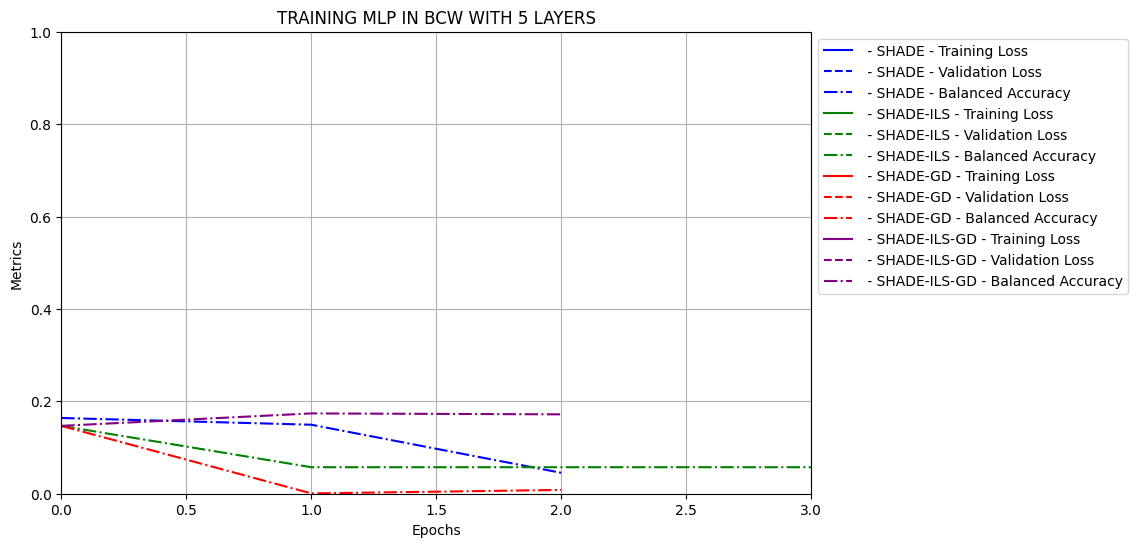

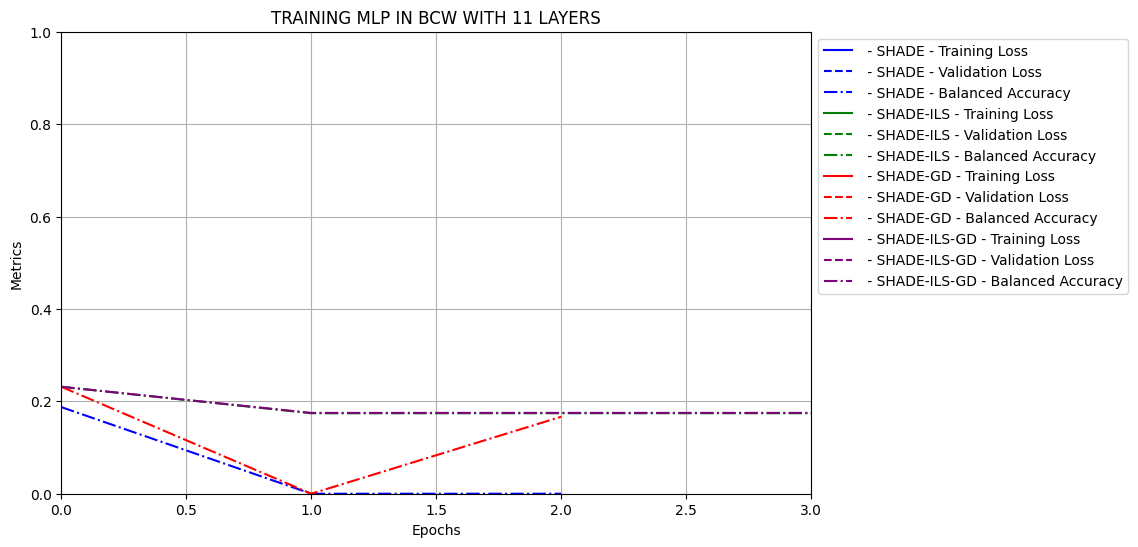

In [ ]:
#Comparing the different MH for the same layer number

names= ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']
train = {}
acc = {}
valid = {}
for layer in n_layers:
  train[layer] = {}
  acc[layer] = {}
  valid[layer] = {}
  for alg in algs:
    train[layer][alg] = training[alg][layer]
    acc[layer][alg] = bal_acc[alg][layer]
    valid[layer][alg] = fitness_valid[alg][layer]
  utilsTFG.plot_mh_mlp_training(train[layer], valid[layer], acc[layer], layers = names, names=names, title=f'TRAINING MLP IN {plot_dataset} WITH {layer} LAYERS')

### Generalization

In [ ]:
#Run the model in the test set
for mh in algs:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    utilsTFG.set_params_to_model(best[mh][layer], mh_learners[layer].model)
    mh_learners[layer].model.eval()
    mh_learners[layer].eval()
    preds, targs = mh_learners[layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    #Calculate balanced accuracy

    ac = utilsTFG.balanced_accuracy_func(preds, targs)


    loss = utilsTFG.err_param_w_model(mh_learners[layer].model, test_dl, mode = 'test')

    print(f"Optimizer: {mh}, Layers: {layer}, Loss: {loss}, Balanced accuracy: {ac}")

Optimizer: SHADE, Layers: 1, Loss: 2.3087034225463867, Balanced accuracy: 0.04366519957438009


Optimizer: SHADE, Layers: 2, Loss: 2.394436836242676, Balanced accuracy: 0.04057971014492754


Optimizer: SHADE, Layers: 5, Loss: 2.3085989952087402, Balanced accuracy: 0.12524271844660195


Optimizer: SHADE, Layers: 11, Loss: 2.3023951053619385, Balanced accuracy: 0.0


Optimizer: SHADE-ILS, Layers: 1, Loss: 1.305456519126892, Balanced accuracy: 0.17785511939163132


Optimizer: SHADE-ILS, Layers: 2, Loss: 1.497733473777771, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-ILS, Layers: 5, Loss: 2.2821567058563232, Balanced accuracy: 0.14591491746668836


Optimizer: SHADE-ILS, Layers: 11, Loss: 2.307281494140625, Balanced accuracy: 0.20641423026444392


Optimizer: SHADE-GD, Layers: 1, Loss: 2.3158130645751953, Balanced accuracy: 0.16107828642572067


Optimizer: SHADE-GD, Layers: 2, Loss: 2.2345786094665527, Balanced accuracy: 0.14990366088631987


Optimizer: SHADE-GD, Layers: 5, Loss: 2.3066158294677734, Balanced accuracy: 0.02296487519564011


Optimizer: SHADE-GD, Layers: 11, Loss: 2.301572561264038, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-ILS-GD, Layers: 1, Loss: 1.286726474761963, Balanced accuracy: 0.16790891887592072


Optimizer: SHADE-ILS-GD, Layers: 2, Loss: 1.2386856079101562, Balanced accuracy: 0.16666666666666666


Optimizer: SHADE-ILS-GD, Layers: 5, Loss: 2.2821567058563232, Balanced accuracy: 0.14591491746668836


Optimizer: SHADE-ILS-GD, Layers: 11, Loss: 2.307281494140625, Balanced accuracy: 0.20641423026444392


## Time comparison

In [ ]:
#Compare times for each algorithm and layer

#GD
for alg, time_layers in time_mh.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {alg} training with {layer} layers: {time:.04f} seconds')

#MH
for optims, time_layers in time_gd.items():
  for layer, time in time_layers.items():
    print(f'Time consumed by {optims} training with {layer} layers: {time:.04f} seconds')



Time consumed by NAG training with 1 layers: 7.8723 seconds
Time consumed by NAG training with 2 layers: 10.9688 seconds
Time consumed by NAG training with 5 layers: 16.6917 seconds
Time consumed by NAG training with 11 layers: 60.7532 seconds
Time consumed by RMSProp training with 1 layers: 4.2405 seconds
Time consumed by RMSProp training with 2 layers: 9.0514 seconds
Time consumed by RMSProp training with 5 layers: 9.7266 seconds
Time consumed by RMSProp training with 11 layers: 36.3470 seconds
Time consumed by ADAM training with 1 layers: 24.4541 seconds
Time consumed by ADAM training with 2 layers: 13.2695 seconds
Time consumed by ADAM training with 5 layers: 15.9552 seconds
Time consumed by ADAM training with 11 layers: 53.5820 seconds
